In [1]:
import copy
import types
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# PyTorch
import torch
import torchvision

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import losses
import utils

In [3]:
def interpolate_checkpoints(first_checkpoint, second_checkpoint, alphas=np.linspace(1.5, -0.5, num=41)):
    interpolations = [{} for _ in range(len(alphas))]
    for index, alpha in enumerate(alphas):
        for key in first_checkpoint.keys():
            interpolations[index][key] = (alpha * copy.deepcopy(first_checkpoint[key].detach())) + ((1-alpha) * copy.deepcopy(second_checkpoint[key].detach()))
            if 'running_var' in key and alpha > 1.0:
                interpolations[index][key] = copy.deepcopy(first_checkpoint[key].detach())
            elif 'running_var' in key and alpha < 0.0:
                interpolations[index][key] = copy.deepcopy(second_checkpoint[key].detach())
    return interpolations

In [4]:
first_checkpoint_path = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI/l2-sp_kappa=23528.522_lr_0=0.01_n=1000_random_state=1001.pt'
second_checkpoint_path = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI/l2-sp_kappa=23528.522_lr_0=0.001_n=1000_random_state=1001.pt'
first_checkpoint = torch.load(first_checkpoint_path, weights_only=False)
second_checkpoint = torch.load(second_checkpoint_path, weights_only=False)
interpolations = interpolate_checkpoints(first_checkpoint, second_checkpoint)

In [5]:
batch_size = 128
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
n = 1000
kappa=23528522/n
num_workers = 0
random_state = 1001
tune = False

augmented_train_dataset, train_dataset, val_or_test_dataset = utils.get_cifar10_datasets(dataset_directory, n, tune, random_state)

augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=min(batch_size, len(augmented_train_dataset)), shuffle=True, num_workers=num_workers, drop_last=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(batch_size, len(train_dataset)), num_workers=num_workers)
val_or_test_loader = torch.utils.data.DataLoader(val_or_test_dataset, batch_size=batch_size, num_workers=num_workers)

num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_losses = []
train_nlls = []
val_losses = []
val_nlls = []
e_train_losses = []
e_train_nlls = []
e_val_losses = []
e_val_nlls = []

for interpolation in interpolations:

    model = torchvision.models.resnet50()
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4, device=device))))
    utils.add_variational_layers(model, model.sigma_param)
    model.use_posterior = types.MethodType(utils.use_posterior, model)
    model.load_state_dict(interpolation)
    model.to(device)
    
    bb_loc = torch.load('/cluster/tufts/hugheslab/eharve06/resnet50_torchvision/resnet50_torchvision_mean.pt', map_location=torch.device('cpu'), weights_only=False).to(device)
    criterion = losses.L2KappaELBOLoss(bb_loc, kappa, model.sigma_param)

    model.use_posterior(False)
    train_metrics = utils.evaluate(model, criterion, train_loader, num_classes=num_classes)
    val_or_test_metrics = utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes)
    train_losses.append(train_metrics['loss'])
    train_nlls.append(train_metrics['nll'])
    val_losses.append(val_or_test_metrics['loss'])
    val_nlls.append(val_or_test_metrics['nll'])
    model.use_posterior(True)
    num_samples = 10
    sample_metrics = [utils.evaluate(model, criterion, train_loader, num_classes=num_classes) for _ in range(num_samples)]
    train_metrics = {key: sum(metrics[key] for metrics in sample_metrics) / num_samples for key in ['acc', 'loss', 'nll']}
    sample_metrics = [utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes) for _ in range(num_samples)]
    val_or_test_metrics = {key: sum(metrics[key] for metrics in sample_metrics) / num_samples for key in ['acc', 'loss', 'nll']}
    e_train_losses.append(train_metrics['loss'])
    e_train_nlls.append(train_metrics['nll'])
    e_val_losses.append(val_or_test_metrics['loss'])
    e_val_nlls.append(val_or_test_metrics['nll'])
    

Files already downloaded and verified
Files already downloaded and verified
cuda:0


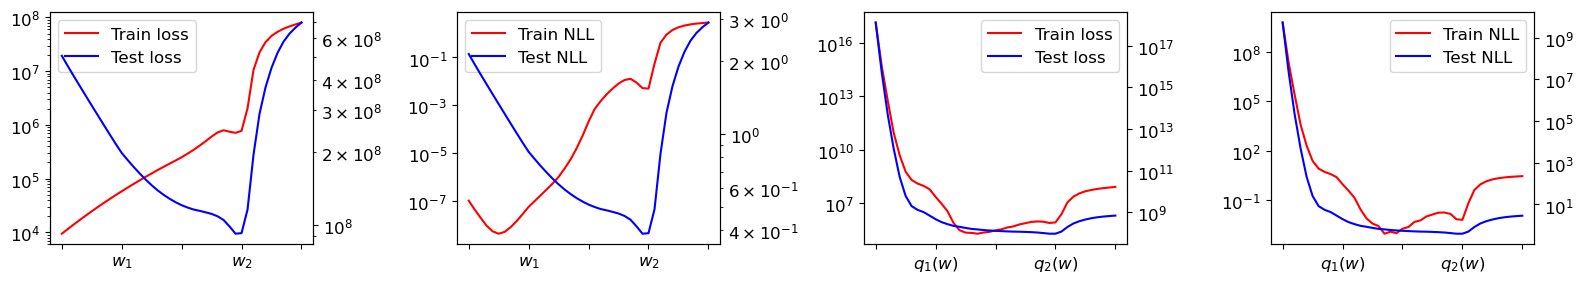

In [6]:
ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
twin_axs = np.empty_like(axs)

axs[0].plot(range(len(train_losses)), train_losses, color='red', label='Train loss')
axs[0].plot([], [], color='blue', label='Test loss')
twin_axs[0] = axs[0].twinx()
twin_axs[0].plot(range(len(val_losses)), val_losses, color='blue')
axs[0].set_xticks([0, 10, 20, 30, 40])
axs[0].set_xticklabels(['', r'$w_1$', '', r'$w_2$', ''])
axs[0].set_yscale('log')
twin_axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(range(len(train_nlls)), train_nlls, color='red', label='Train NLL')
axs[1].plot([], [], color='blue', label='Test NLL')
twin_axs[1] = axs[1].twinx()
twin_axs[1].plot(range(len(val_nlls)), val_nlls, color='blue')
axs[1].set_xticks([0, 10, 20, 30, 40])
axs[1].set_xticklabels(['', r'$w_1$', '', r'$w_2$', ''])
axs[1].set_yscale('log')
twin_axs[1].set_yscale('log')
axs[1].legend()

axs[2].plot(range(len(e_train_losses)), e_train_losses, color='red', label='Train loss')
axs[2].plot([], [], color='blue', label='Test loss')
twin_axs[2] = axs[2].twinx()
twin_axs[2].plot(range(len(e_val_losses)), e_val_losses, color='blue')
axs[2].set_xticks([0, 10, 20, 30, 40])
axs[2].set_xticklabels(['', r'$q_1(w)$', '', r'$q_2(w)$', ''])
axs[2].set_yscale('log')
twin_axs[2].set_yscale('log')
axs[2].legend()

axs[3].plot(range(len(e_train_nlls)), e_train_nlls, color='red', label='Train NLL')
axs[3].plot([], [], color='blue', label='Test NLL')
twin_axs[3] = axs[3].twinx()
twin_axs[3].plot(range(len(e_val_nlls)), e_val_nlls, color='blue')
axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xticklabels(['', r'$q_1(w)$', '', r'$q_2(w)$', ''])
axs[3].set_yscale('log')
twin_axs[3].set_yscale('log')
axs[3].legend()

fig.tight_layout()
plt.show()